*** 
                                    The following are data descriptions.
***
***
**Id**-an Id that represents a (Store, Date) duple within the test set<br>
**Store**-a unique Id for each store<br>
**Sales** - the turnover for any given day (this is what you are predicting)<br>
**Customers** - the number of customers on a given day<br>
**Open** - an indicator for whether the store was open: `0 = closed, 1 = open`<br>
**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all<br>
**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all<br>
schools are closed on public holidays and weekends.`a = public holiday, b = Easter holiday, c = Christmas, 0 = None`<br>
**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools<br>
**StoreType** - differentiates between 4 different store models: a, b, c, d<br>
**Assortment** - describes an assortment level: `a = basic, b = extra, c = extended.` Read more about assortment here<br>
**CompetitionDistance** - distance in meters to the nearest competitor store<br>
**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened<br>
**Promo** - indicates whether a store is running a promo on that day<br>
**Promo2** - Promo2 is a continuing and consecutive promotion for some stores:`0 = store is not participating, 1 = store is participating`<br>
**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2<br>
**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
***

In [51]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#for easy access to path
import sys
import os

#importing packages for data manuplation and visualization
import numpy as np
import pandas as pd
import math

# Modelling Algorithm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Modelling Helpers
#from sklearn.preprocessing import Imputer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Visualization Configuration
%matplotlib inline
sns.set()

In [2]:
#Acessing scripts and data path
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts/')

In [3]:
#import local libraries
from clean_train_test_df import CleanStoreDf
from data_preview import DataPreview
from data_loader import load_df_from_csv
from data_manipulation import DataManipulator
from plots import *
from result import ResultPicker

In [4]:
#reading our data
pd.set_option('max_column', None)
pd.set_option('max_rows', None)

store_df=pd.read_csv('../data/store.csv')
train_df=pd.read_csv('../data/train.csv')
test_df=pd.read_csv('../data/test.csv')

#creating an object
store_data=DataPreview(store_df)
train_data=DataPreview(train_df)
test_data=DataPreview(test_df)

In [5]:
results = ResultPicker()

###### STORE DATASET

In [6]:
#check if the data has null values
missing = store_data.percent_missing(store_df)
results.add_data('missing_data',missing)
missing

#get the missing percenatage in each columns
store_data.missing_values_table()

The dataset contains 21.01 % missing values.


,total_missing_values,missing_percentage
Promo2SinceWeek,544,48.79 %
Promo2SinceYear,544,48.79 %
PromoInterval,544,48.79 %
CompetitionOpenSinceMonth,354,31.75 %
CompetitionOpenSinceYear,354,31.75 %
CompetitionDistance,3,0.27 %
Store,0,0.0 %
StoreType,0,0.0 %
Assortment,0,0.0 %
Promo2,0,0.0 %


> The store data has 21.01% missing values.
>>`Promo2SinceWeek`,`Promo2SinceYear` and `PromoInterval` has higher missing values and need to be dropped.	

###### TRAIN DATASET AND TEST DATASET

In [7]:
train_data.show_datatypes()

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [8]:
test_data.show_datatypes()

Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [9]:
#check if the data has null values
train_data.percent_missing(train_df)
test_data.percent_missing(test_df)

The dataset contains 0.0 % missing values.
The dataset contains 0.0 % missing values.


>Both `Train` and `Test` dataset has no missing vlaues.

In [10]:
#changin the datatype
train_data_cleaner = CleanStoreDf(train_df)
test_data_cleaner = CleanStoreDf(test_df)

In [11]:
train_data_cleaner.change_column_to_date_type('Date')
test_data_cleaner.change_column_to_date_type('Date')

In [12]:
test_data_cleaner.df.dtypes

Id                        int64
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Open                    float64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

>The `Date` column was object type and need to be changed for extracting the year,months and days.<br>
>The data type of date column is changed to datetime as seen in the output

In [13]:
# Separating date for train and test
train_data_cleaner.separate_date_column(date_column='Date')
test_data_cleaner.separate_date_column(date_column='Date')

In [18]:
train_data_cleaner.df.dtypes

Store             int64
DayOfWeek         int64
Year              int64
Month             int64
Day               int64
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

>The date column is separated into `Year`,`Month` and `Day`.

#### Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?

<AxesSubplot:xlabel='Promo', ylabel='Density'>

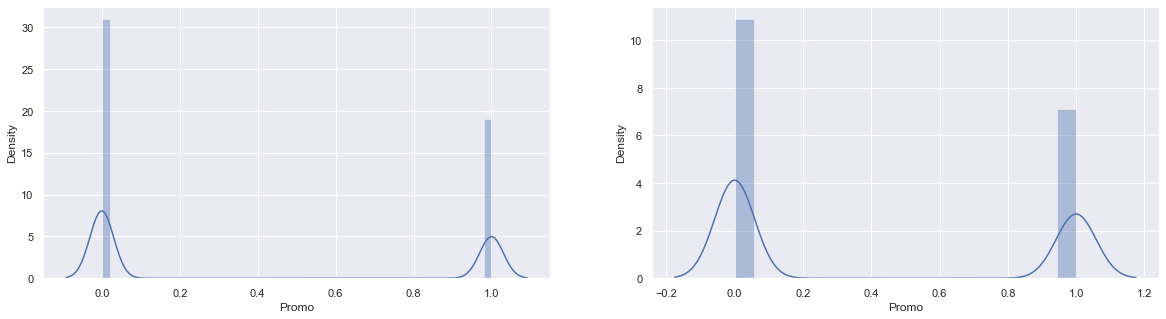

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(train_df['Promo'],ax=axs[0])#.set_title('Distribution of Train Promo)
sns.distplot(test_df['Promo'],ax=axs[1])#.set_title('Distribution of Test Promo')


>Distribution of Train and Test Promo

<AxesSubplot:xlabel='Year', ylabel='Promo'>

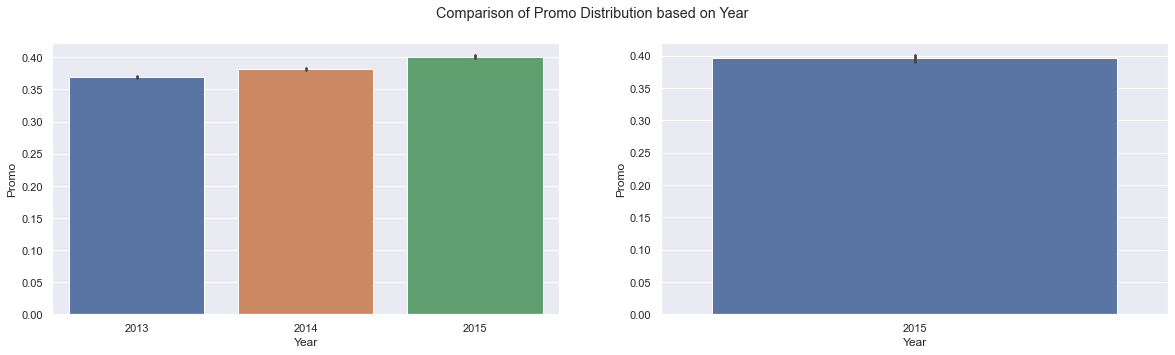

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Comparison of Promo Distribution based on Year')
sns.barplot('Year',"Promo", data=train_df,ax=axs[0])
sns.barplot('Year',"Promo", data=test_df,ax=axs[1])

>Promotion was used only in 2015 for test data while  it was used for three consecutive years for train.